In [18]:
import random
import sys
sys.path += ['..']

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, RandomSampler
from torchvision import datasets, transforms
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from experiments_utils import CifarTransformsSupervised
from supervised_train import train as train_supervised
from supervised_train import test as test_supervised

from byol_from_scratch.model import BYOL
from byol_from_scratch.train import train_byol
from byol_from_scratch.transforms import SimCLR_Transforms
from byol_from_scratch.utils import display_images

In [2]:
torch.manual_seed(42)
random.seed(42)

DEVICE = 'cuda'
BATCH_SIZE = 128
RESULTS = {}

### Supervised classification learning

In [3]:
class Resnet18WithCustomHead(nn.Module):
    def __init__(self, num_classes: int, freeze_resnet: bool):
        super().__init__()
        self._model = resnet18(pretrained=True)
        for param in self._model.parameters():
            param.requires_grad = not freeze_resnet
        self._model.fc = nn.Linear(512, num_classes)
    def forward(self, x):
        return self._model(x)

In [4]:
def train_test_supervised(
    model: nn.Module,
    train_dl: DataLoader,
    test_dl: DataLoader,
    learning_rate: float,
):   
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model = train_supervised(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        train_dl=train_dl,
        num_epochs=10,
        device=DEVICE
    )

    test_result = test_supervised(
        model=model,
        test_dl=test_dl,
        device=DEVICE
    )
    
    return test_result

In [5]:
train_ds_supervised = datasets.CIFAR10(root='../data', train=True, download=True, transform=CifarTransformsSupervised)
test_ds_supervised = datasets.CIFAR10(root='../data', train=False, download=True, transform=CifarTransformsSupervised)

train_dl_supervised = DataLoader(train_ds_supervised, batch_size=BATCH_SIZE, shuffle=True)
test_dl_supervised = DataLoader(test_ds_supervised, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


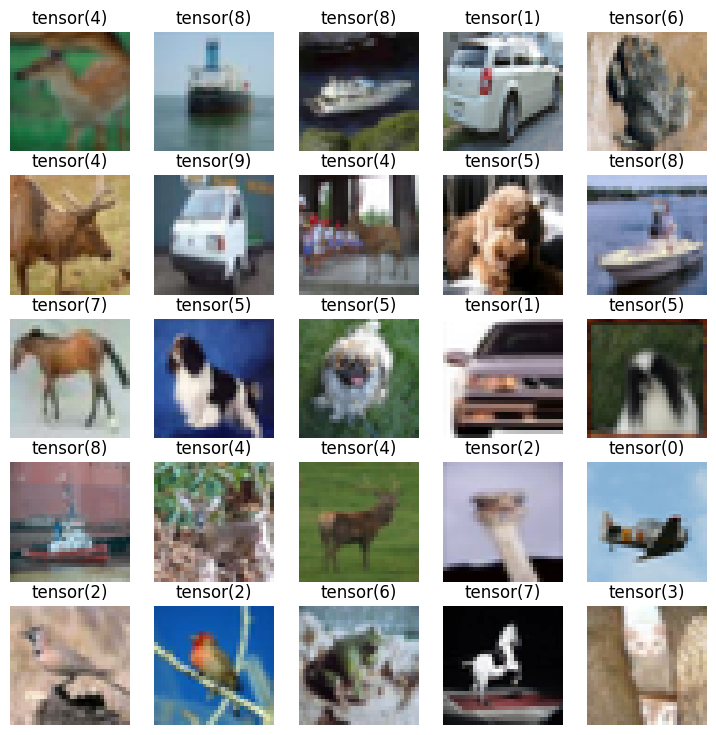

In [6]:
images_first_batch, labels_first_batch = next(iter(train_dl_supervised))
display_images(images_first_batch, labels_first_batch)

In [7]:
resnet18_with_custom_head = Resnet18WithCustomHead(num_classes=10, freeze_resnet=True)
RESULTS['freezed (without BYOL)'] = train_test_supervised(
    model=resnet18_with_custom_head,
    train_dl=train_dl_supervised,
    test_dl=test_dl_supervised,
    learning_rate=0.001
)

/home/cybertech/tomekg/BYOL from scratch/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cybertech/tomekg/BYOL from scratch/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 10/10 [00:25<00:00,  2.52s/it, Epoch=9, loss=597, accuracy=0.47]


Accuracy of the network on the test images: 0.465


In [8]:
resnet18_with_custom_head = Resnet18WithCustomHead(num_classes=10, freeze_resnet=False)
RESULTS['unfreezed (without BYOL)'] = train_test_supervised(
    model=resnet18_with_custom_head,
    train_dl=train_dl_supervised,
    test_dl=test_dl_supervised,
    learning_rate=0.001
)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:37<00:00,  3.77s/it, Epoch=9, loss=43.4, accuracy=0.963]


Accuracy of the network on the test images: 0.8152


### BYOL

/home/cybertech/tomekg/BYOL from scratch/.venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


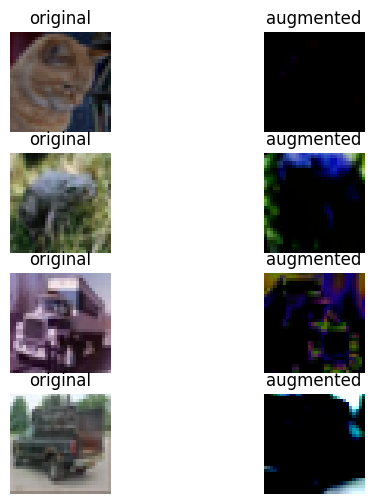

In [9]:
images_first_batch, _ = next(iter(train_dl_supervised))
simclr_transforms = SimCLR_Transforms(image_size=32, normalize=True)
aug_images = simclr_transforms(images_first_batch)

combined_images = []
for i in range(4):
    combined_images.append(images_first_batch[i].unsqueeze(0))
    combined_images.append(aug_images[i].unsqueeze(0))
combined_images = torch.cat(combined_images, dim=0)

display_images(
    combined_images, 
    sample_random=False, 
    labels=["original", "augmented"] * 4, 
    rows=4, 
    columns=2, 
    size=6, 
    unnorm=True
    )

In [10]:
def train_resnet_18_with_byol(
    num_epochs: int,
    train_dl: DataLoader,
    pretrained_resnet: bool,
    device: str,
    learning_rate: float
):
    resnet18_model = resnet18(pretrained=pretrained_resnet)
    byol_model = BYOL(
        base_model=resnet18_model, 
        image_size=32, 
        projection_hidden_size=4096, 
        projection_size=256, 
        moving_avg_decay=0.99
    )
    optimizer = optim.Adam(byol_model.parameters(), lr=learning_rate)
    byol_model = train_byol(
        model=byol_model,
        train_dl=train_dl,
        optimizer=optimizer,
        epochs=num_epochs,
        device=device
    )
    return byol_model

class BYOLWithCustomHead(nn.Module):
    def __init__(self, byol: nn.Module, num_classes: int, freeze_byol: bool):    
        super().__init__()
        self.byol = byol
        for param in self.byol.parameters():
            param.requires_grad = not freeze_byol
        self._clf_head = nn.LazyLinear(num_classes)
    
    def forward(self, x: torch.Tensor):
        return self._clf_head(self.byol(x, get_embedding=True))

### Experiment

In [11]:
train_ds_byol = datasets.CIFAR10(root='../data', train=True, download=False, transform=transforms.ToTensor())

In [12]:
TRAIN_DS_KEEP_PERCS_BYOL = [0.1, 0.5, 0.8]

for train_ds_keep_perc_byol in TRAIN_DS_KEEP_PERCS_BYOL:
    random_sampler = RandomSampler(
        train_ds_byol, 
        num_samples=int(len(train_ds_byol) * train_ds_keep_perc_byol),
        replacement=False
        )
    train_dl_byol = DataLoader(train_ds_byol, batch_size=BATCH_SIZE, sampler=random_sampler)
    
    byol_model = train_resnet_18_with_byol(
        num_epochs=50,
        train_dl=train_dl_byol,
        pretrained_resnet=True,
        device=DEVICE,
        learning_rate=0.0001
    )
    byol_with_custom_head = BYOLWithCustomHead(byol_model, num_classes=10, freeze_byol=True)
    test_result = train_test_supervised(
        model=byol_with_custom_head,
        train_dl=train_dl_supervised,
        test_dl=test_dl_supervised,
        learning_rate=0.001
    )
    RESULTS[f'freezed (with BYOL - {train_ds_keep_perc_byol})'] = test_result
    
    print(f"Train DS keep perc BYOL: {train_ds_keep_perc_byol}, Test accuracy: {round(test_result, 3)}")

/home/cybertech/tomekg/BYOL from scratch/.venv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:25<00:00,  2.57s/it, Epoch=9, loss=403, accuracy=0.633]


Accuracy of the network on the test images: 0.6407
Train DS keep perc BYOL: 0.1, Test accuracy: 0.641


100%|██████████| 10/10 [00:26<00:00,  2.62s/it, Epoch=9, loss=307, accuracy=0.726]


Accuracy of the network on the test images: 0.7275
Train DS keep perc BYOL: 0.5, Test accuracy: 0.728


100%|██████████| 10/10 [00:26<00:00,  2.62s/it, Epoch=9, loss=286, accuracy=0.745]


Accuracy of the network on the test images: 0.7427
Train DS keep perc BYOL: 0.8, Test accuracy: 0.743


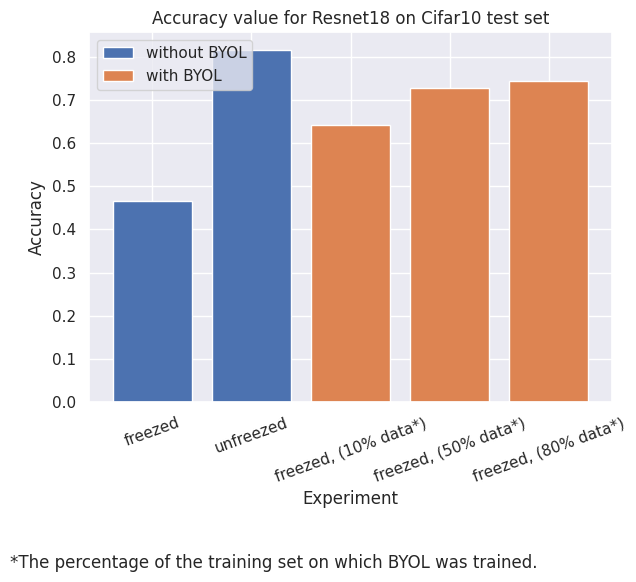

In [20]:
f, ax = plt.subplots(1, 1)
ax.bar(
    ['freezed', 'unfreezed'],
    [RESULTS['freezed (without BYOL)'], RESULTS['unfreezed (without BYOL)']],
    label='without BYOL',
)
ax.bar(
    ['freezed, (10% data*)', 'freezed, (50% data*)', 'freezed, (80% data*)'],
    [RESULTS['freezed (with BYOL - 0.1)'], RESULTS['freezed (with BYOL - 0.5)'], RESULTS['freezed (with BYOL - 0.8)']],
    label='with BYOL',
)
ax.set_title("Accuracy value for Resnet18 on Cifar10 test set")
ax.set_xlabel("Experiment")
ax.set_ylabel("Accuracy")
f.text(0, -.2, '*The percentage of the training set on which BYOL was trained.', ha='left')

plt.tight_layout()
plt.xticks(rotation=20)
plt.legend(loc='upper left')
plt.show()